In [13]:
import pandas as pd
import numpy as np
import os
import time
import json
import joblib
import importlib
from collections import defaultdict 
from datetime import datetime
from scipy.sparse import save_npz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import config
from config import PROCESSED_DATA_DIR, TRAIN_FILE, TEST_FILE, VAL_FILE, TEXT_COLUMN, PERSON_COUPLE_COLUMN, RANDOM_STATE

In [16]:
def load_and_flatten_json(file_path):
    """
    Loads a nested JSON file and flattens it into a DataFrame.
    Concatenates dialogue turns into a single text string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    processed_data = []
    for conversation in data:
        dialogue_text = " ".join(
            [f"[{turn['speaker']}] {turn['text']}" for turn in conversation['dialogue']]
        )
        processed_data.append({
            TEXT_COLUMN: dialogue_text,
            PERSON_COUPLE_COLUMN: conversation[PERSON_COUPLE_COLUMN]
        })
        
    return pd.DataFrame(processed_data)


def load_and_flatten_json_generic_speakers(file_path):
    """
    Loads a nested JSON file and flattens it into a DataFrame.
    Concatenates dialogue turns into a single text string, replacing specific
    speaker names with generic 'A' and 'B' labels.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    processed_data = []
    for conversation in data:
        speaker_map = {}
        dialogue_text_parts = []
        
        for turn in conversation['dialogue']:
            speaker = turn['speaker']
            
            if speaker not in speaker_map:
                # Assign 'A' to the first unique speaker and 'B' to the second
                if not speaker_map:
                    speaker_map[speaker] = 'A'
                elif len(speaker_map) == 1:
                    speaker_map[speaker] = 'B'
            
            # Use the mapped label ('A' or 'B')
            generic_speaker = speaker_map.get(speaker, speaker)
            dialogue_text_parts.append(f"[{generic_speaker}] {turn['text']}")
            
        dialogue_text = " ".join(dialogue_text_parts)
        
        processed_data.append({
            TEXT_COLUMN: dialogue_text,
            PERSON_COUPLE_COLUMN: conversation[PERSON_COUPLE_COLUMN]
        })
        
    return pd.DataFrame(processed_data)

In [17]:
# Load training and test data using the new function
print("Loading data")
train_path = os.path.join(PROCESSED_DATA_DIR, TRAIN_FILE)
test_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)

df_train = load_and_flatten_json(train_path)
df_test = load_and_flatten_json(test_path)

print(f"Training data: {df_train.shape[0]} rows")
print(f"Test data: {df_test.shape[0]} rows")
df_train.head()

Loading data
Training data: 700 rows
Test data: 150 rows


,conversation,person_couple
0,"[Turio] ""Sono ancora in piedi i mobili che ave...",Perfezionista Critico e Insicura Cronica
1,"[Giulietto] ""Hai ricevuto il mio messaggio di ...",Manipolatore e Dipendente emotiva
2,"[Rizzano] ""Cosa vuoi che faccia per migliorare...",Geloso-Ossessivo e Sottomessa
3,"[Illiano] ""Perché è rimasto lì tanto a guardar...",Controllore e Isolata
4,"[Cina] ""Perché sei così depressa? Non hai il p...",Psicopatico e Adulatrice


In [18]:
# Prepare data
X_train = df_train[TEXT_COLUMN]
y_train_labels = df_train[PERSON_COUPLE_COLUMN]

X_test = df_test[TEXT_COLUMN]
y_test_labels = df_test[PERSON_COUPLE_COLUMN]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

print("\nUnique classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))


Unique classes: ['Controllore e Isolata' 'Dominante e Schiavo emotivo'
 'Geloso-Ossessivo e Sottomessa' 'Manipolatore e Dipendente emotiva'
 'Narcisista e Succube' 'Perfezionista Critico e Insicura Cronica'
 'Persona violenta e Succube' 'Psicopatico e Adulatrice'
 'Sadico-Crudele e Masochista' 'Vittimista e Croccerossina']
Number of classes: 10


In [19]:
# Vectorize text with TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Training TF-IDF matrix shape:", X_train_tfidf.shape)

Training TF-IDF matrix shape: (700, 10000)


In [20]:
# Define and train Logistic Regression model with GridSearchCV
print("\nTraining model with GridSearchCV")
start_time = time.time()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Training model with GridSearchCV
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training time: 18.66 seconds
Best parameters found: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.7328571428571429


c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\llm_env_py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [21]:
# 1. Get best model and predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
y_pred_probs = best_model.predict_proba(X_test_tfidf)
y_test_array = np.array(y_test)

print("\n" + "="*80)
print("                           MODEL EVALUATION RESULTS")
print("="*80)

# 2. Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# 3. Get the indices of the top 2 and top 3 most likely classes
top2_preds_indices = np.argsort(y_pred_probs, axis=1)[:, -2:]
top3_preds_indices = np.argsort(y_pred_probs, axis=1)[:, -3:]

# 4. Build a list of dictionaries with all metrics per class
results_data = []
for class_index, class_name in enumerate(label_encoder.classes_):
    class_metrics = report_dict.get(class_name, {})
    indices_of_class = np.where(y_test_array == class_index)[0]
    
    class_top2_accuracy = 0.0
    class_top3_accuracy = 0.0
    if len(indices_of_class) > 0:
        class_correct_top2_count = np.sum([y_test_array[i] in top2_preds_indices[i] for i in indices_of_class])
        class_top2_accuracy = class_correct_top2_count / len(indices_of_class)
        
        class_correct_top3_count = np.sum([y_test_array[i] in top3_preds_indices[i] for i in indices_of_class])
        class_top3_accuracy = class_correct_top3_count / len(indices_of_class)

    results_data.append({
        'Precision': class_metrics.get('precision', 0),
        'Recall (Top-1 Acc)': class_metrics.get('recall', 0),
        'F1-Score': class_metrics.get('f1-score', 0),
        'Top-2 Accuracy': class_top2_accuracy,
        'Top-3 Accuracy': class_top3_accuracy,
        'Support': int(class_metrics.get('support', 0))
    })

# 5. Create the final pandas DataFrame
results_df = pd.DataFrame(results_data, index=label_encoder.classes_)
results_df.index.name = "Class"

print("\nPerformance Report per Class")

# Format the float columns to display as percentages
formatted_df = results_df.copy()
for col in ['Precision', 'Recall (Top-1 Acc)', 'F1-Score', 'Top-2 Accuracy', 'Top-3 Accuracy']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")

print(formatted_df.to_string()) 

overall_accuracy = report_dict.get('accuracy', 0)
overall_top2_accuracy = np.sum([y_test_array[i] in top2_preds_indices[i] for i in range(len(y_test_array))]) / len(y_test_array)
overall_top3_accuracy = np.sum([y_test_array[i] in top3_preds_indices[i] for i in range(len(y_test_array))]) / len(y_test_array)

weighted_avg_metrics = report_dict.get('weighted avg', {})
overall_recall = weighted_avg_metrics.get('recall', 0)
overall_f1 = weighted_avg_metrics.get('f1-score', 0)

print("\n" + "-"*80)
print("Overall Performance Summary:")
print(f"  - Accuracy (Top-1): {overall_accuracy:.2%}")
print(f"  - Recall (Weighted Avg): {overall_recall:.2%}")
print(f"  - F1-Score (Weighted Avg): {overall_f1:.2%}")
print(f"  - Top-2 Accuracy:   {overall_top2_accuracy:.2%}")
print(f"  - Top-3 Accuracy:   {overall_top3_accuracy:.2%}")
print("="*80)


                           MODEL EVALUATION RESULTS

Performance Report per Class
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       70.00%             93.33%   80.00%         93.33%         93.33%       15
Dominante e Schiavo emotivo                 71.43%             90.91%   80.00%         90.91%         90.91%       11
Geloso-Ossessivo e Sottomessa               85.71%             75.00%   80.00%         87.50%        100.00%        8
Manipolatore e Dipendente emotiva           66.67%             50.00%   57.14%         81.25%         93.75%       16
Narcisista e Succube                        64.29%             60.00%   62.07%         86.67%         93.33%       15
Perfezionista Critico e Insicura Cronica    78.57%             68.75%   73.33%         81.2

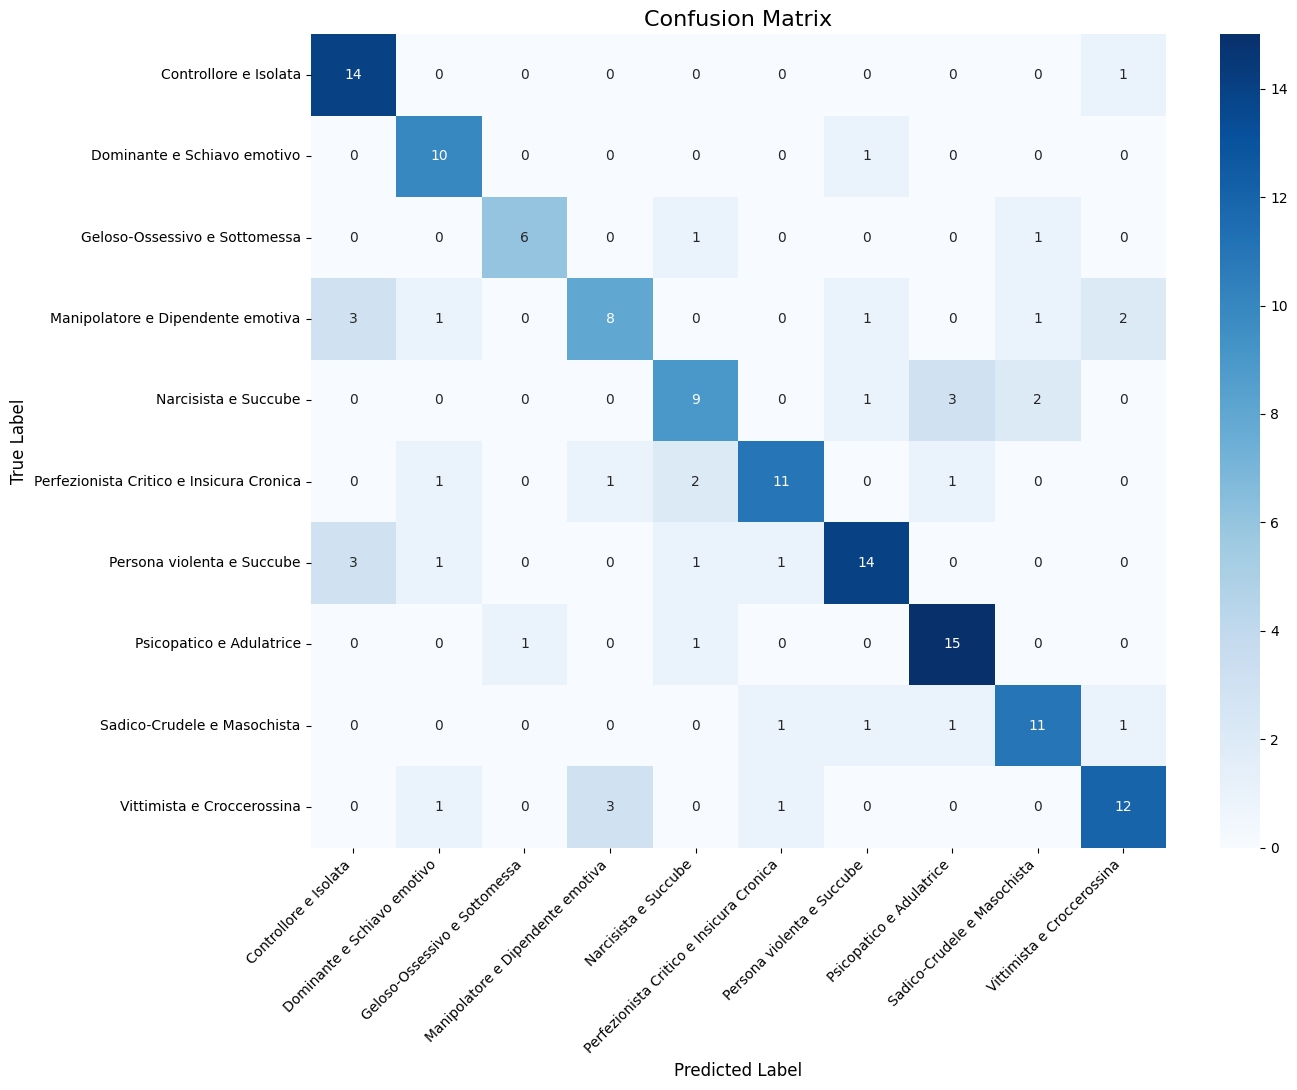

In [22]:

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = label_encoder.classes_, columns = label_encoder.classes_)


plt.figure(figsize=(14, 11))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
